# Perkenalan
Nama : Arvin Melvillo \
Batch : FTDS - RMT - 020 \
Dataset : [Big Query Credit Card Default](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=ml_datasets&t=credit_card_default&page=table) \
Latar belakang : Sebuah bank sedang melakukan pengecekan mengenai penggunaan kartu kredit nasabahnya. Tanpa disengaja admin melihat bahwa ada beberapa kartu kredit yang sudah melewati batas jatuh tempo peminjamannya. Oleh karena itu, bank ingin membuat sebuah model yang dapat memprediksi pembatalan kartu kredit untuk bulan depan. \
Objective : Memprediksi apakah kartu kredit pengguna akan ditutup atau tidak bulan depan \
Pengerjaan : Pada kasus ini, data scientist akan memprediksi dengan menggunakan 6 model yaitu **Logistic Regression**, **SVM**, **KNN**, **Naive Bayes**, **Decision Tree**, dan **Random Forest**. Nantinya 2 model dengan performa terbaik pada base modelnya akan di tuning lagi, lalu model terbaik setelah dituning akan disimpan untuk melakukan prediksi pembatalan kartu kredit di bulan depannya. Metrics yang digunakan adalah F1-score untuk menghitung performa model baik dari nilai False Positive ataupun False Negativenya. Karena pembatalan kartu kredit merupakan kasus yang cukup sensitif dimana kesalahan mengenai prediksi penutupan kartu kredit dapat berakibat fatal. Sehingga kita perlu melihat f1-score yang merupakan nilai representasi dari precision dan recall, dimana pada kasus ini kita ingin melihat **seberapa banyak kartu kredit yang diprediksi akan ditutup** dan **seberapa banyak kartu kredit yang benar benar akan ditutup**.

# Query SQL
```sql
SELECT 
limit_balance, cast(sex as int) sex, cast(education_level as int) education_level, 
cast(marital_status as int) marital_status, age, pay_0, pay_2, 
pay_3, pay_4, cast(pay_5 as FLOAT64) pay_5, cast(pay_6 as FLOAT64) pay_6, 
bill_amt_1, bill_amt_2, bill_amt_3, bill_amt_4, bill_amt_5, 
bill_amt_6, pay_amt_1, pay_amt_2, pay_amt_3, pay_amt_4, pay_amt_5, pay_amt_6, 
cast(default_payment_next_month as int) as default_payment_next_month
FROM `bigquery-public-data.ml_datasets.credit_card_default`
-- Lahir Tahun 1999 * Batch 20
LIMIT 39980
```

# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json

# Library for split, standardrize, and encode the dataset
from sklearn.model_selection import train_test_split #Split
from sklearn.preprocessing import MinMaxScaler #Scale

# For handle outlier
from feature_engine.outliers import Winsorizer

# For Feature Selection
from sklearn.feature_selection import chi2

# For Model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# For Hyperparameter and cros validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score

# Data Loading

In [2]:
data = pd.read_csv("payment_default.csv")

In [3]:
data

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0


In [4]:
data.duplicated().sum() # Melihat data total data duplikat

1

In [5]:
data = data.drop_duplicates() # Menghapus data duplikat

In [6]:
data_copy = data.copy()

In [7]:
data.head(10) # Memanggil 10 data pertama

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
5,300000.0,2,4,2,32.0,0.0,0.0,0.0,0.0,0.0,...,65150.0,-450.0,700.0,15235.0,1491.0,1303.0,0.0,2000.0,1400.0,0
6,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,0.0,...,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
7,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,0.0,...,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
8,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,0.0,...,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
9,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,0.0,...,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0


In [8]:
data.tail(10) # Memanggil 10 data terakhir

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2955,360000.0,2,2,2,26.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,463.0,2500.0,0.0,0.0,0.0,0.0,0
2956,100000.0,1,3,1,40.0,0.0,0.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,2000.0,2377.0,40000.0,0.0,0.0,0.0,0
2957,30000.0,2,3,1,48.0,1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0
2958,80000.0,2,3,1,39.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,5000.0,5000.0,5000.0,0.0,5000.0,5000.0,470.0,0
2959,20000.0,1,3,2,26.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,1560.0,0.0,0.0,0.0,0.0,0.0,0
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0
2964,290000.0,2,2,1,39.0,1.0,-2.0,-2.0,-2.0,-2.0,...,3184.0,390.0,390.0,10000.0,800.0,3184.0,390.0,390.0,6617.0,0


# Explarotary Data Analysis 

Sebelum memulai analisa data, mari lihat total data, tipe - tipe data, dan missing value pada data ini.

In [9]:
data.shape

(2964, 24)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2964 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2964 non-null   float64
 1   sex                         2964 non-null   int64  
 2   education_level             2964 non-null   int64  
 3   marital_status              2964 non-null   int64  
 4   age                         2964 non-null   float64
 5   pay_0                       2964 non-null   float64
 6   pay_2                       2964 non-null   float64
 7   pay_3                       2964 non-null   float64
 8   pay_4                       2964 non-null   float64
 9   pay_5                       2964 non-null   float64
 10  pay_6                       2964 non-null   float64
 11  bill_amt_1                  2964 non-null   float64
 12  bill_amt_2                  2964 non-null   float64
 13  bill_amt_3                  2964 non-n

In [11]:
data.isnull().sum()

limit_balance                 0
sex                           0
education_level               0
marital_status                0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt_1                    0
bill_amt_2                    0
bill_amt_3                    0
bill_amt_4                    0
bill_amt_5                    0
bill_amt_6                    0
pay_amt_1                     0
pay_amt_2                     0
pay_amt_3                     0
pay_amt_4                     0
pay_amt_5                     0
pay_amt_6                     0
default_payment_next_month    0
dtype: int64

Data pada kasus ini tidak memiliki data yang NULL atau missing values. Namun apakah data ini memiliki cardinality yang tinggi?

In [12]:
data.nunique()

limit_balance                   59
sex                              2
education_level                  7
marital_status                   4
age                             49
pay_0                           11
pay_2                           10
pay_3                            9
pay_4                           10
pay_5                            9
pay_6                            8
bill_amt_1                    2643
bill_amt_2                    2592
bill_amt_3                    2549
bill_amt_4                    2504
bill_amt_5                    2482
bill_amt_6                    2461
pay_amt_1                     1415
pay_amt_2                     1372
pay_amt_3                     1302
pay_amt_4                     1214
pay_amt_5                     1194
pay_amt_6                     1189
default_payment_next_month       2
dtype: int64

Data sex, education_level, marital_status,  pay_0, pay_2, pay_3, pay_4, pay_5, pay_6 tidak memiliki cardinality yang tinggi. Tapi data - data amount memiliki cardinality yang tinggi

In [13]:
for i in data:
    print(f'Unique data of {i}: ', data[i].unique())

Unique data of limit_balance:  [ 80000. 200000.  20000. 260000. 150000. 300000. 130000. 500000. 230000.
 460000. 780000. 170000. 320000. 290000. 240000. 340000. 360000. 380000.
 180000. 100000.  90000.  50000. 160000.  70000. 280000. 220000.  30000.
 120000.  10000. 470000. 310000. 140000.  60000. 110000. 430000. 210000.
 490000. 330000. 250000. 400000. 370000. 440000. 700000. 530000. 390000.
 410000. 270000. 560000.  40000. 680000. 480000. 190000. 350000. 420000.
 510000. 800000. 450000. 750000. 620000.]
Unique data of sex:  [1 2]
Unique data of education_level:  [6 4 1 2 3 5 0]
Unique data of marital_status:  [1 2 3 0]
Unique data of age:  [54. 49. 22. 33. 32. 45. 58. 39. 48. 34. 47. 46. 30. 35. 55. 42. 56. 31.
 53. 40. 36. 51. 37. 44. 24. 38. 26. 25. 23. 27. 28. 29. 41. 63. 50. 43.
 66. 61. 52. 62. 69. 21. 65. 57. 64. 67. 60. 59. 68.]
Unique data of pay_0:  [ 0.  2.  1. -1. -2.  3.  4.  5.  6.  7.  8.]
Unique data of pay_2:  [ 0. -1.  2.  3. -2.  4.  1.  5.  6.  7.]
Unique data of p

Setelah mendapat data unique di setiap column, mari cek distribusi pengelompokkan data **default_payment_next_month**

<Axes: ylabel='default_payment_next_month'>

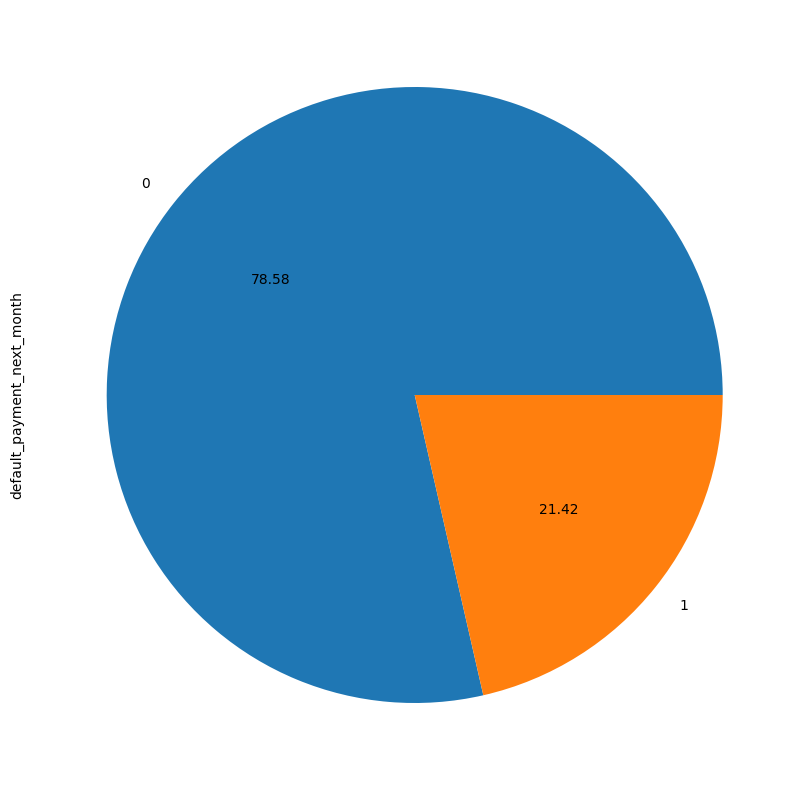

In [14]:
data.groupby('default_payment_next_month')['default_payment_next_month'].count().plot.pie(y='default_payment_next_month', autopct='%0.2f', figsize=(10,10))

Data pada kasus ini cukup tidak imbang atau **imbalance**. Dikatakan karena data - data yang kartu kreditnya ditutup hanya sebanyak **21,42%** saja dari keseluruhan data

Skew of limit_balance: 1.0006047564306488
Skew of pay_0: 0.9276720756106166


Skew of pay_2: 0.8624687970101019
Skew of pay_3: 0.9321840116222396
Skew of pay_4: 1.102317023326789
Skew of pay_5: 1.060916090705517
Skew of pay_6: 0.9793187194607118


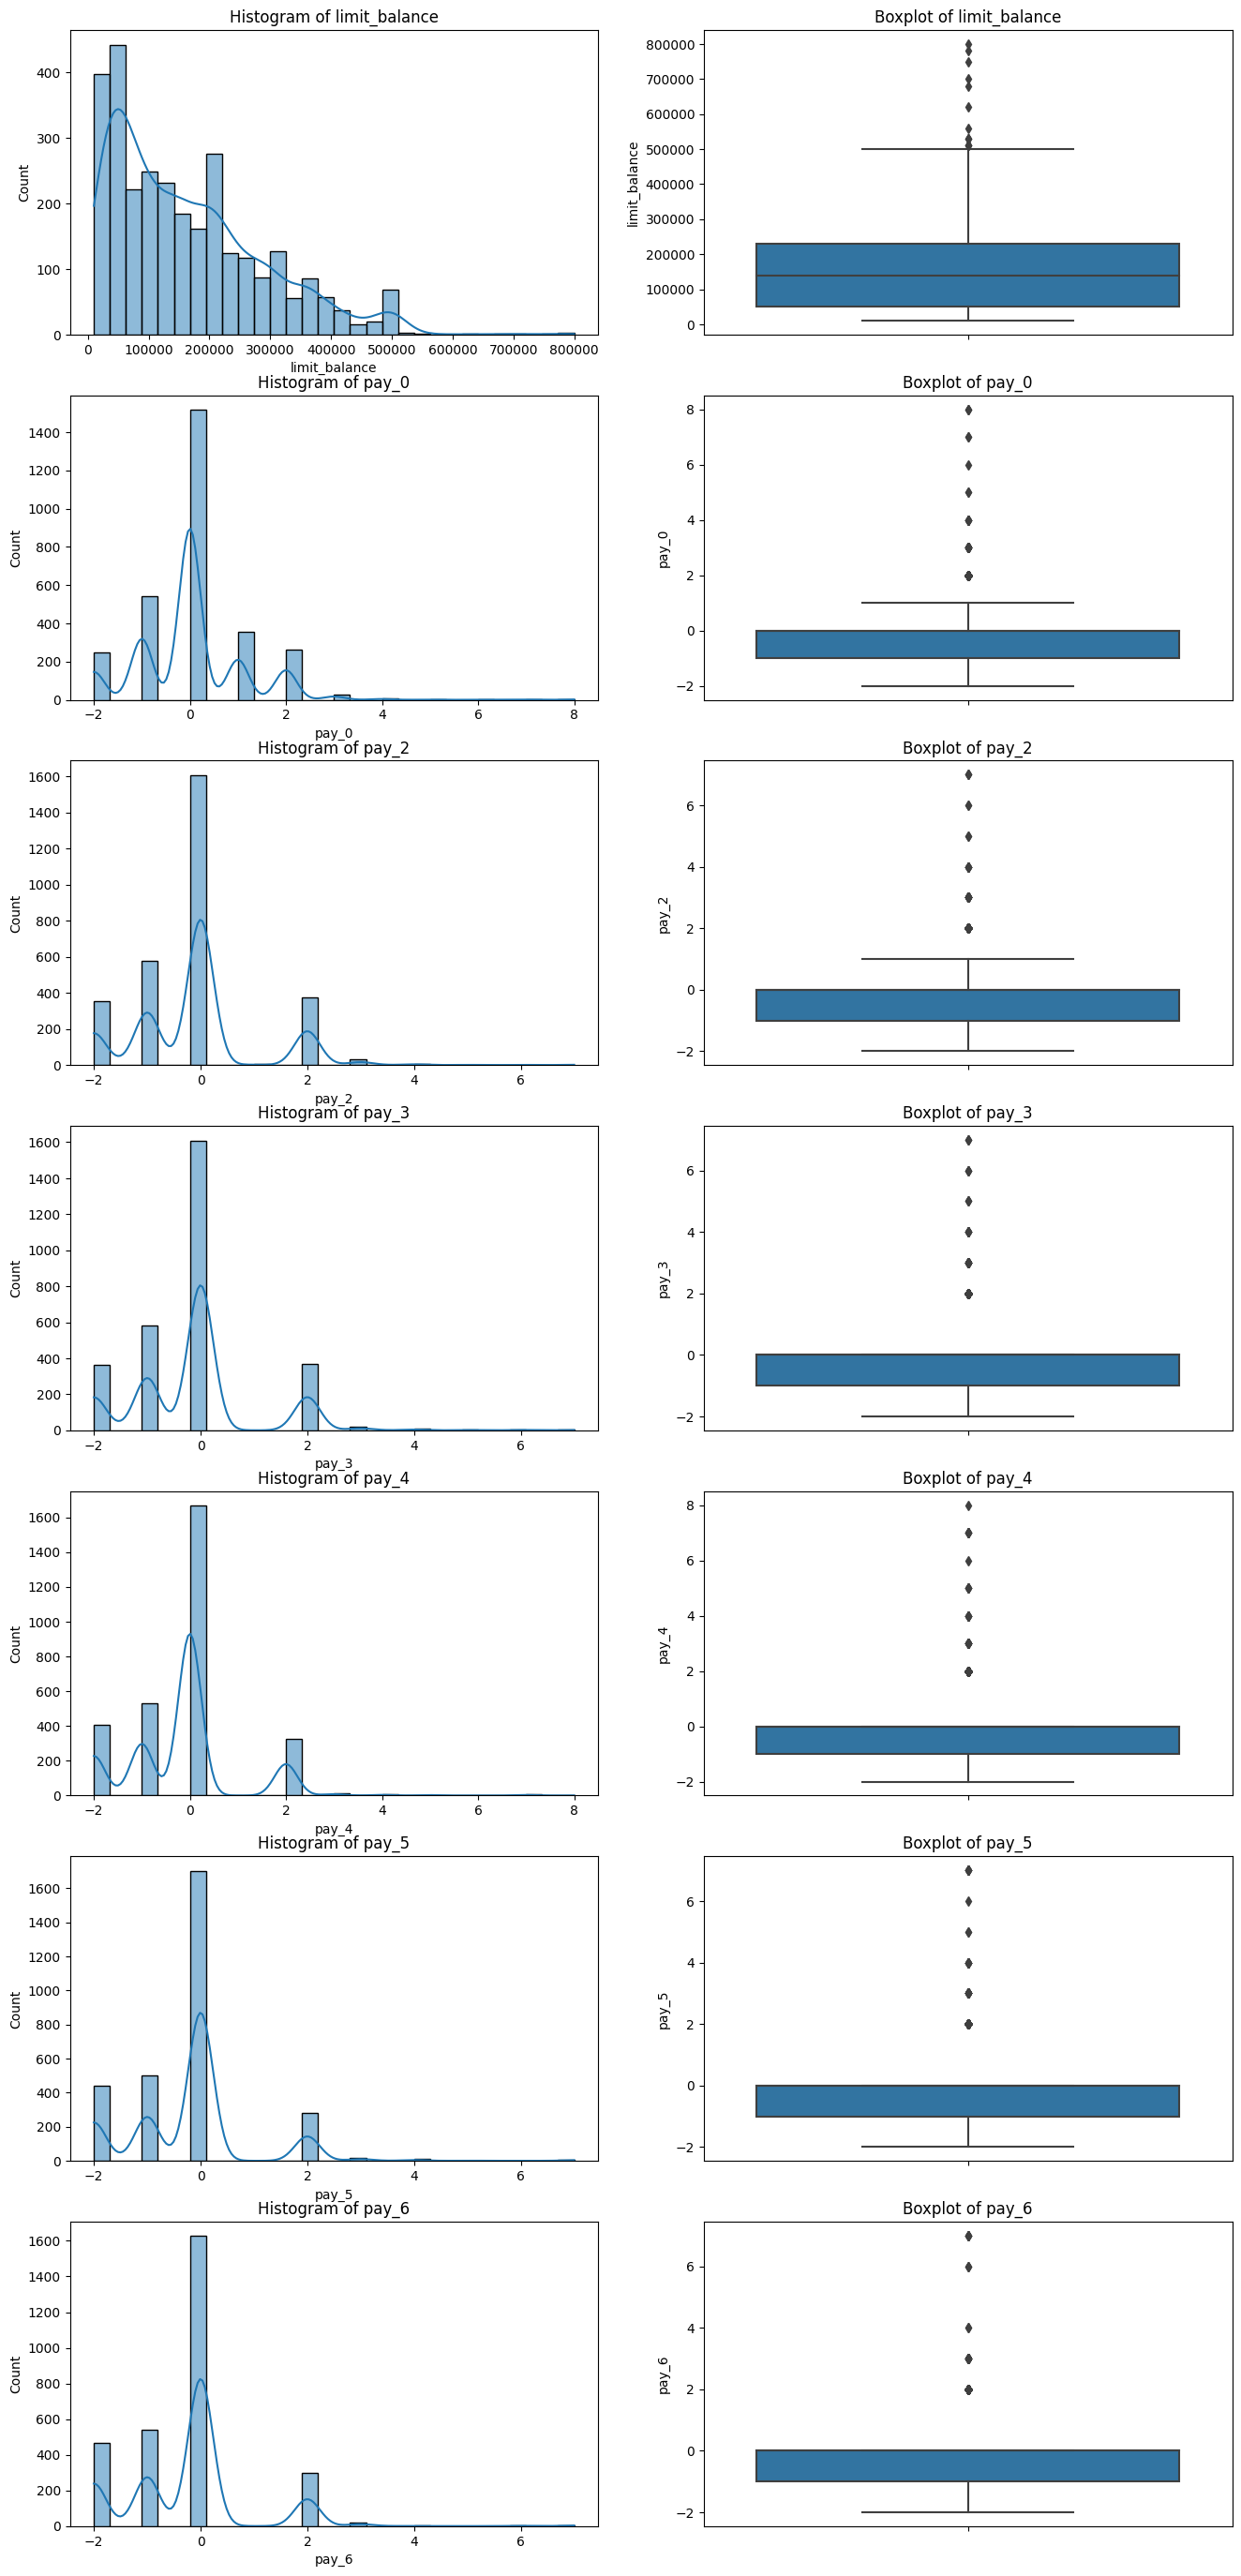

In [15]:
check_1 = ['limit_balance','pay_0','pay_2','pay_3','pay_4','pay_5','pay_6']
total_col = len(check_1)
plt.figure(figsize=(16, total_col * 10))
i = 1
for col in check_1:
    plt.subplot(total_col * 2, 2, i)
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    i += 1

    plt.subplot(total_col * 2, 2, i)
    sns.boxplot(y=data[col])
    plt.title(f'Boxplot of {col}')
    print(f'Skew of {col}:',data[col].skew())
    i += 1

plt.show()

Data limit balance dan pay memiliki distribusi data yang condong ke kiri dan tidak terpusat

Skew of age: 0.7726317877077615
Skew of bill_amt_1: 2.4842290445797968
Skew of bill_amt_2: 2.4579711014121437
Skew of bill_amt_3: 2.569558864308388
Skew of bill_amt_4: 2.447791627637353
Skew of bill_amt_5: 2.399943857538142
Skew of bill_amt_6: 2.4319995109017865


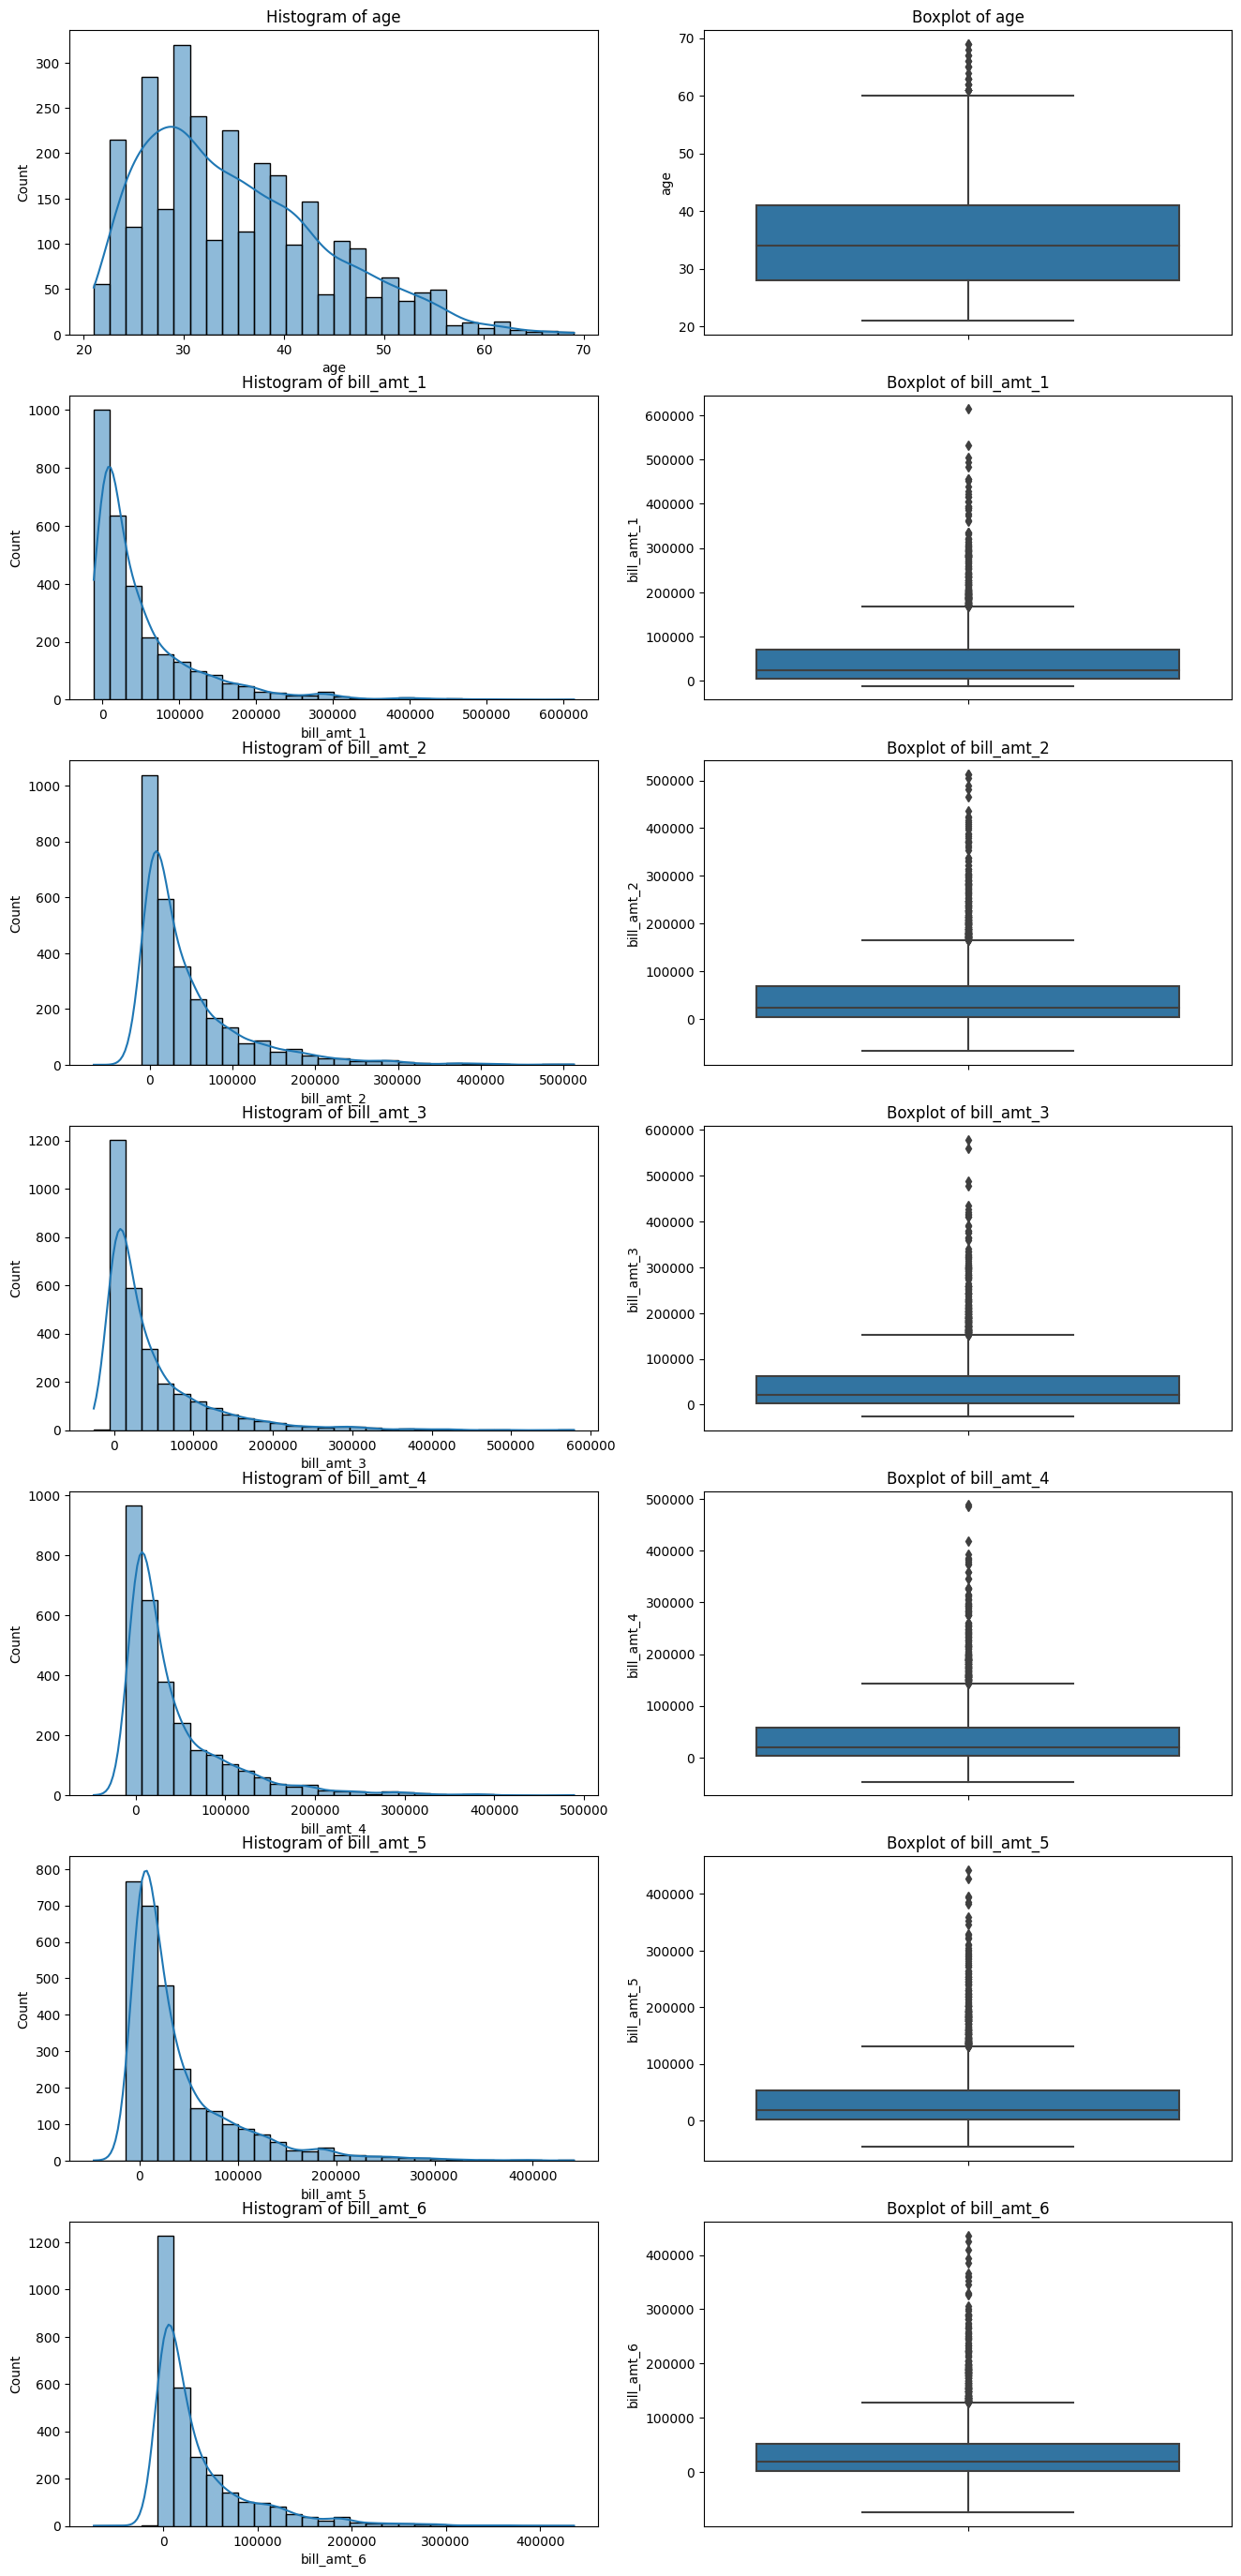

In [16]:
check_2 = ['age','bill_amt_1','bill_amt_2','bill_amt_3','bill_amt_4','bill_amt_5','bill_amt_6']
total_col = len(check_2)
plt.figure(figsize=(16, total_col * 10))
i = 1
for col in check_2:
    plt.subplot(total_col * 2, 2, i)
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    i += 1

    plt.subplot(total_col * 2, 2, i)
    sns.boxplot(y=data[col])
    plt.title(f'Boxplot of {col}')
    print(f'Skew of {col}:',data[col].skew())
    i += 1

plt.show()

Data bill amount memiliki distribusi data yang cenderung ke kiri dan tidak terpusat

Skew of pay_amt_1: 11.87590259977231
Skew of pay_amt_2: 29.39979237780383
Skew of pay_amt_3: 8.043463398022954
Skew of pay_amt_4: 8.450287705274073
Skew of pay_amt_5: 11.467169258420292
Skew of pay_amt_6: 9.758714356332968


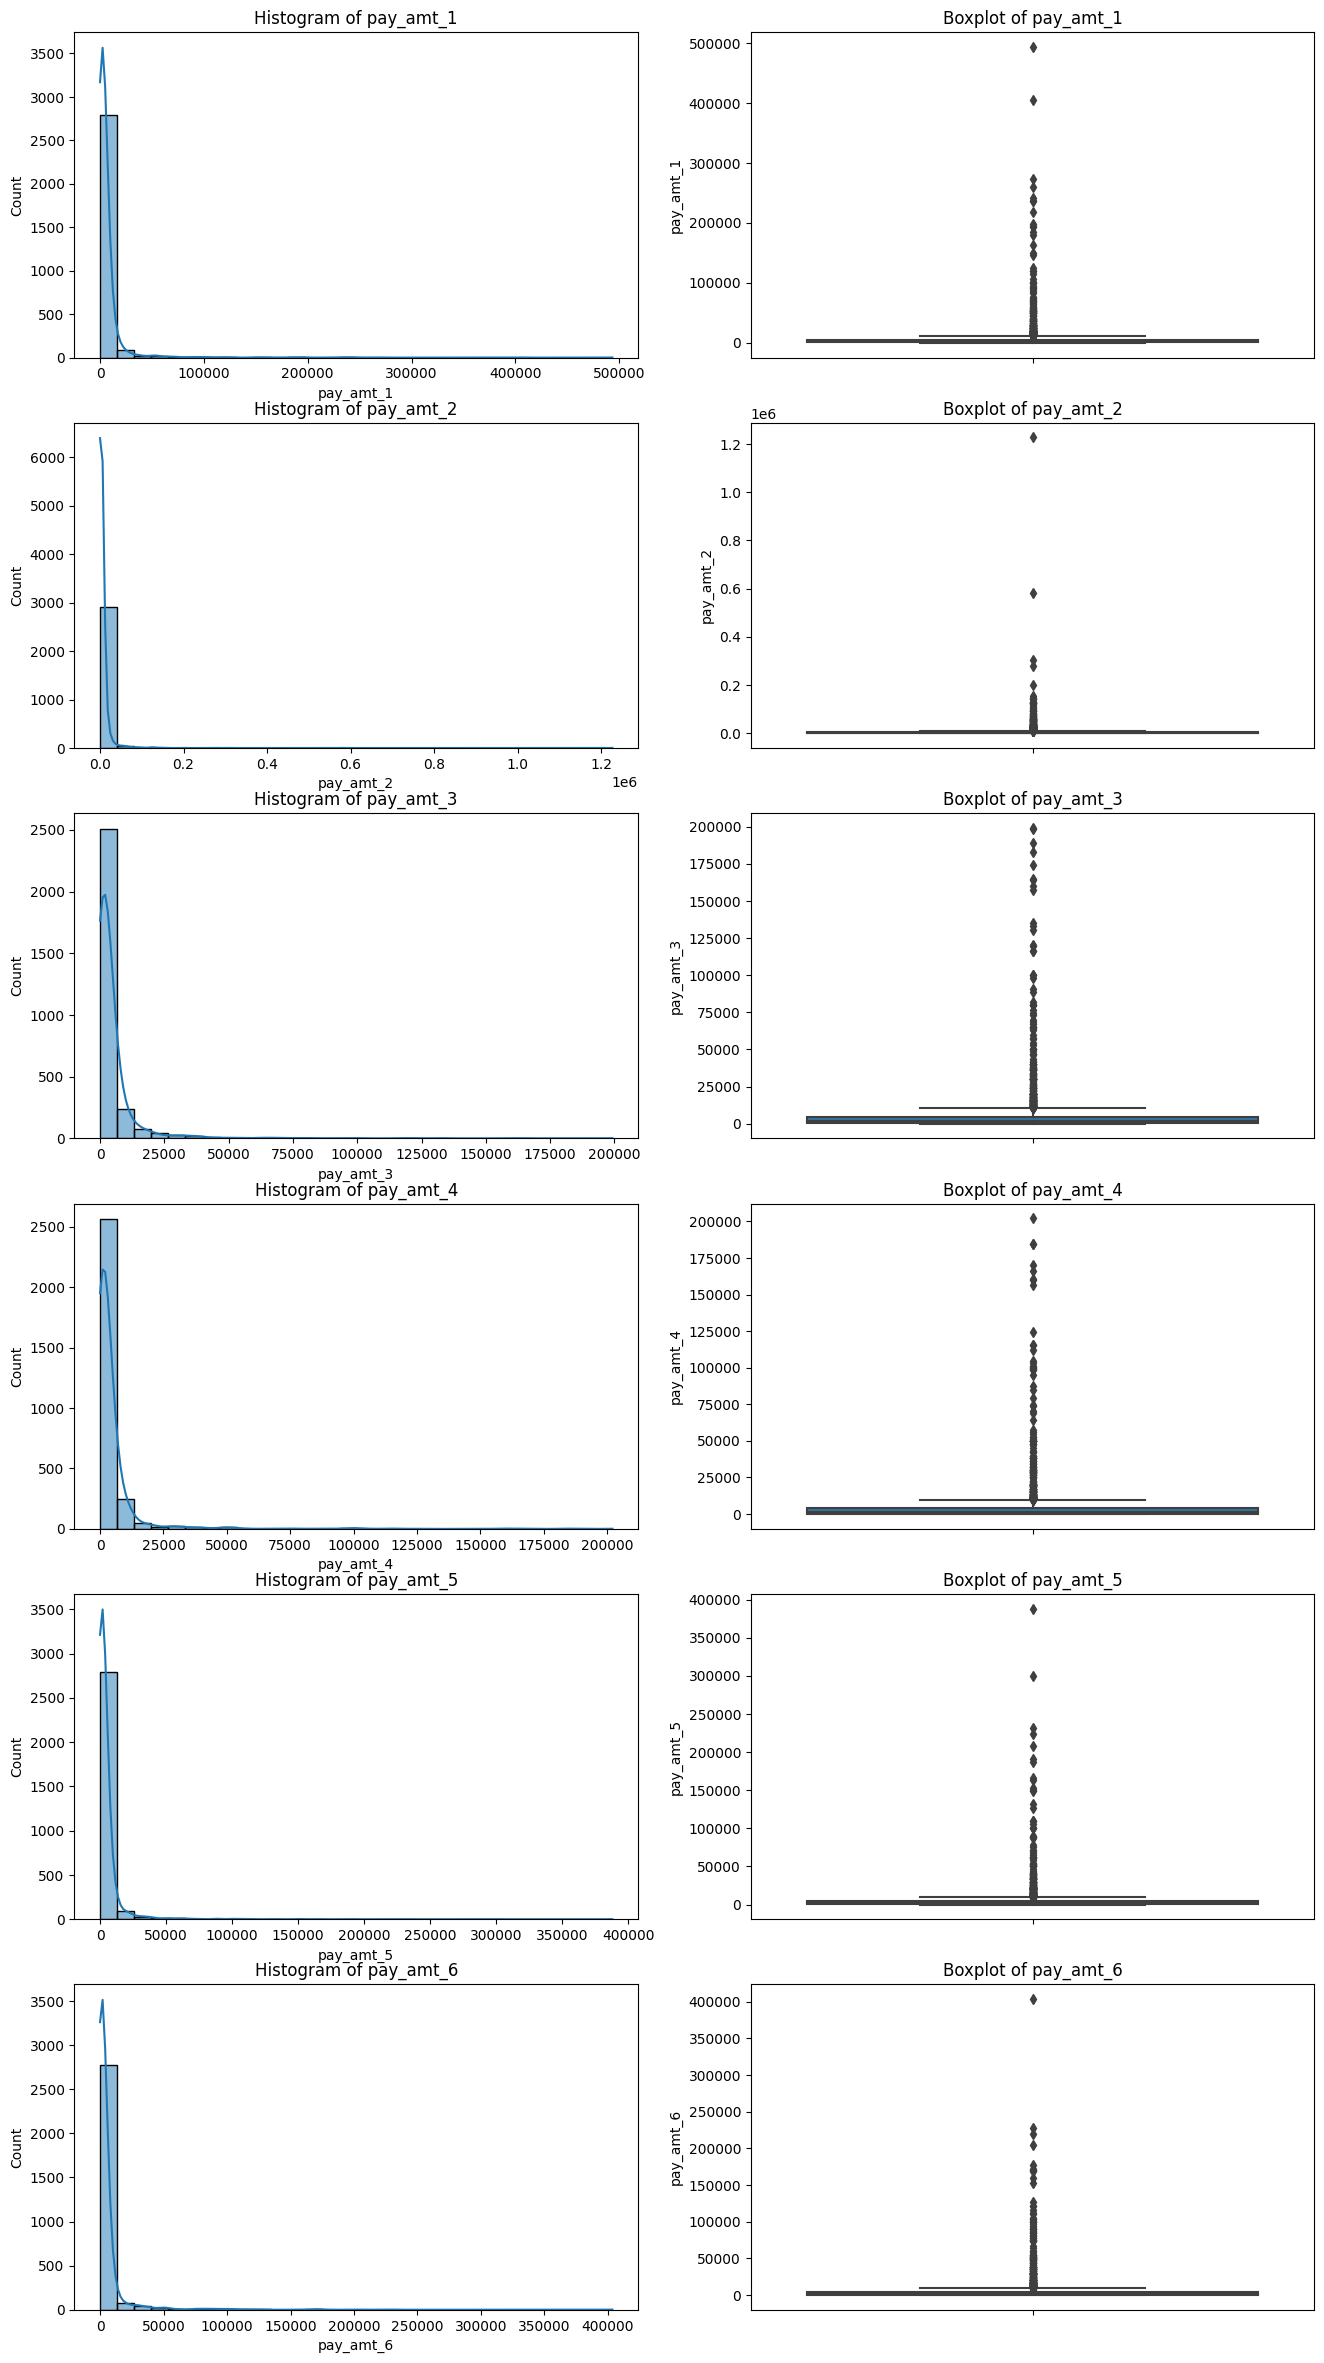

In [17]:
check_3 = ['pay_amt_1','pay_amt_2','pay_amt_3','pay_amt_4','pay_amt_5','pay_amt_6']
total_col = len(check_3)
plt.figure(figsize=(16, total_col * 10))
i = 1
for col in check_3:
    plt.subplot(total_col * 2, 2, i)
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    i += 1

    plt.subplot(total_col * 2, 2, i)
    sns.boxplot(y=data[col])
    plt.title(f'Boxplot of {col}')
    print(f'Skew of {col}:',data[col].skew())
    i += 1

plt.show()

Data pay amount memiliki distribusi data yang cenderung ke kiri dan tidak terpusat

<Axes: >

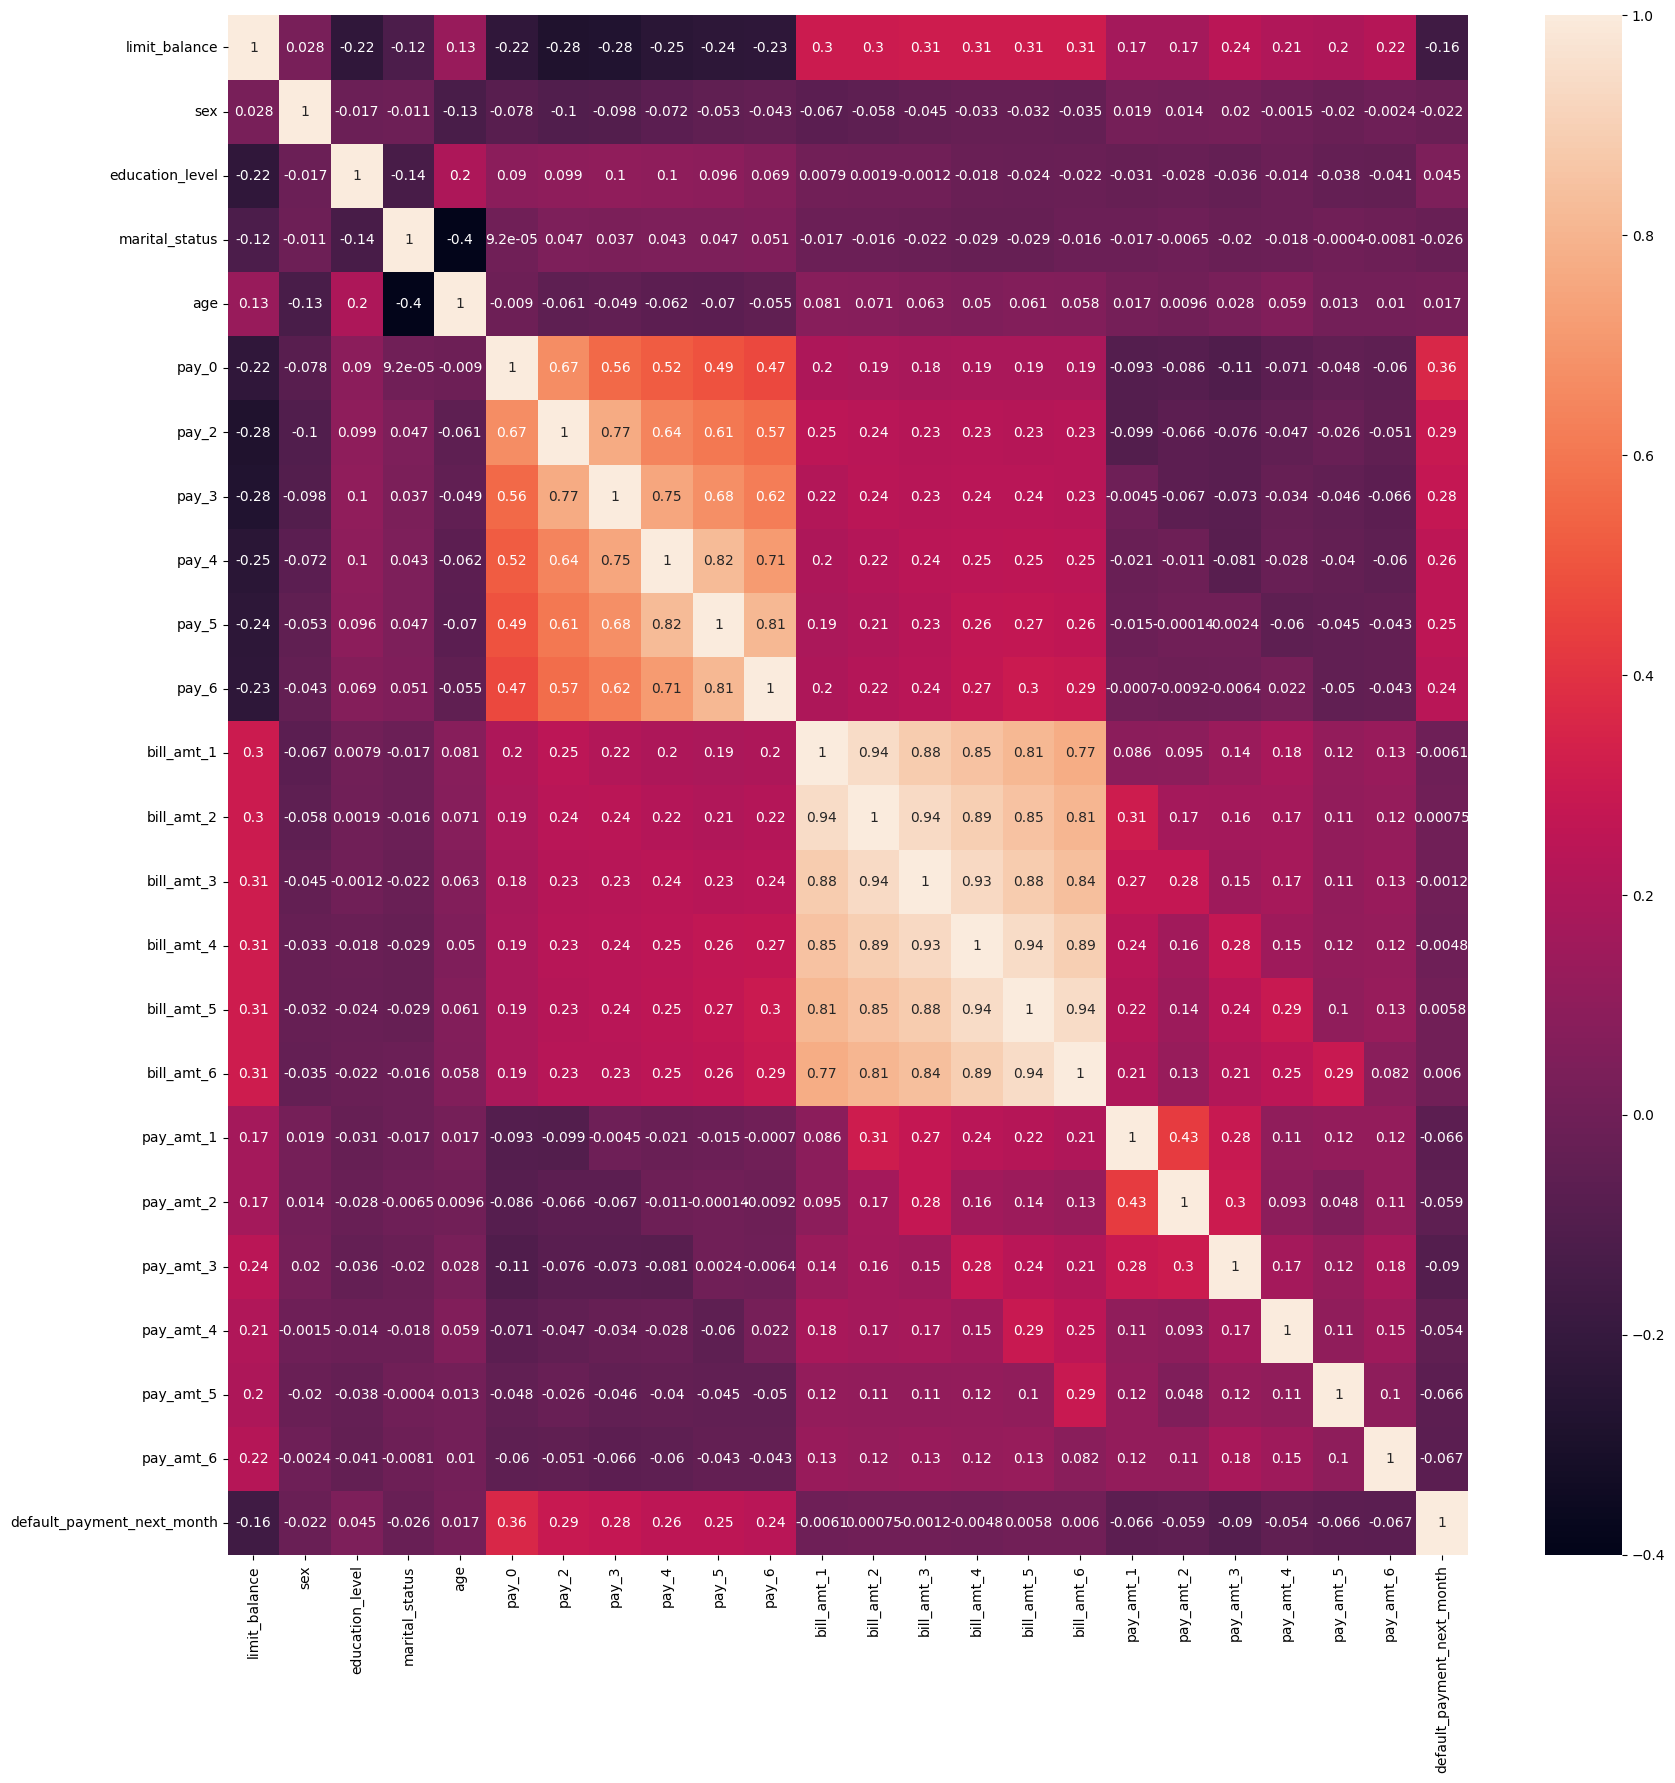

In [18]:
#Membuat heatmap untuk melihat korelasi dengan data categorical dengan data price
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(), annot=True)

Hanya data pay yang memiliki korelasi atau keterkaitan dengan data **default_payment_next_month** dengan nilai korelasi diatas **0.2**. Namun pada data category, tidak dapat dilihat berdasarkan nilai korelasi saja keterhubungannya. Perlu dilakukan Chi-square test untuk melakukan pengecekan keterhubungan data category dengan data **default_payment_next_month**. Dimana p-value yang dibawah 0.05 memiliki keterkaitan yang signifikan dengan data **default_payment_next_month**

In [19]:
chi_scores_cat = chi2(data[['sex','education_level','marital_status']], data['default_payment_next_month'])

In [20]:
p_values_cat = pd.Series(chi_scores_cat[1],index = ['sex','education_level','marital_status'])
p_values_cat.sort_values(ascending = False , inplace = True)

In [21]:
p_values_cat

sex                0.650247
marital_status     0.551033
education_level    0.163471
dtype: float64

<Axes: >

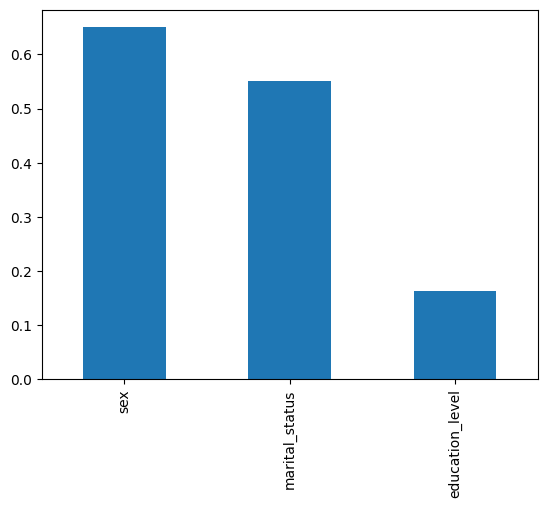

In [22]:
p_values_cat.plot.bar()

Dari hasil analisa dan visualisasi diatas, tidak ada data category yang signifikan berhubungan dengan data **default_payment_next_month**. Dimana data yang digunakan hanya berasal dari data numerical yang korelasinya diatas **0.2** yaitu data - data **pay** saja

# Feature Engineering

## Split X and y between Train-set and Test-set

Melakukan split pada data X dan y. Dimana data X merupakan data dependen sedangkan data y merupakan data target. Dalam kasus ini data targetnya ialah **default_payment_next_month**

In [23]:
#Split x dan y
X = data.drop(['default_payment_next_month'], axis=1)
y = data['default_payment_next_month']
X

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,...,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,...,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,...,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,...,27086.0,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,...,161192.0,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,-2.0,...,0.0,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0
2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,-2.0,...,5880.0,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0
2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0
2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

print('Train Size : ', X_train.shape)
print('Test Size : ', X_test.shape)
X_train

Train Size :  (2371, 23)
Test Size :  (593, 23)


,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
708,30000.0,2,2,2,24.0,0.0,0.0,0.0,0.0,0.0,...,27238.0,27012.0,26762.0,25900.0,2500.0,2000.0,2000.0,1916.0,1000.0,1100.0
1776,50000.0,2,2,1,38.0,2.0,0.0,0.0,2.0,2.0,...,33850.0,34495.0,35129.0,35918.0,2000.0,3500.0,1500.0,1500.0,1500.0,1500.0
1226,50000.0,2,3,1,29.0,0.0,0.0,0.0,0.0,0.0,...,49054.0,7378.0,8103.0,8963.0,2500.0,3125.0,417.0,1000.0,1000.0,500.0
2710,170000.0,2,2,1,31.0,0.0,0.0,0.0,0.0,-2.0,...,63000.0,0.0,0.0,3300.0,5000.0,4000.0,0.0,0.0,3300.0,0.0
2419,290000.0,2,2,2,41.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,980.0,4059.0,2473.0,3332.0,6891.0,980.0,4059.0,2473.0,3332.0,3203.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1341,400000.0,2,1,2,29.0,0.0,0.0,2.0,0.0,0.0,...,70557.0,71867.0,72137.0,72955.0,7017.0,0.0,3200.0,2750.0,3000.0,5800.0
1026,100000.0,2,2,2,25.0,2.0,0.0,0.0,0.0,0.0,...,70125.0,69856.0,69718.0,51365.0,3472.0,2092.0,2000.0,2127.0,1960.0,1559.0
1450,290000.0,1,2,1,43.0,-1.0,-1.0,2.0,0.0,0.0,...,1752.0,3710.0,3848.0,4285.0,1930.0,0.0,2000.0,200.0,500.0,0.0
1669,30000.0,1,2,2,33.0,0.0,0.0,0.0,0.0,0.0,...,29400.0,30000.0,0.0,0.0,2233.0,1000.0,600.0,0.0,0.0,0.0


## Handle Missing Value

Tidak ada missing value pada dataset ini

## Handle Outlier

Melakukan pengecekan pada outlier

In [25]:
#Fungsi untuk mendapatkan upper limit dan lower limit
def find_limit(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_limit = df[variable].quantile(0.25) - (IQR * distance)
    upper_limit  = df[variable].quantile(0.75) + (IQR * distance)

    return upper_limit, lower_limit

In [26]:
outlier_check = ['limit_balance',
 'pay_0',
 'pay_2',
 'pay_3',
 'pay_4',
 'pay_5',
 'pay_6',
 'bill_amt_1',
 'bill_amt_2',
 'bill_amt_3',
 'bill_amt_4',
 'bill_amt_5',
 'bill_amt_6',
 'pay_amt_1',
 'pay_amt_2',
 'pay_amt_3',
 'pay_amt_4',
 'pay_amt_5',
 'pay_amt_6']
data_outlier_check = {}
for i in outlier_check:
        data_outlier_check[f'{i}_upper_limit'], data_outlier_check[f'{i}_lower_limit'] = find_limit(X_train, i, 1.5)

In [27]:
print('Full data:', X_train.shape)
for i in outlier_check:
    print(f'Data without {i} outlier:',
        X_train[(X_train[i] >= data_outlier_check[f'{i}_lower_limit']) & (X_train[i] <= data_outlier_check[f'{i}_upper_limit'])].shape)
    print(f'Percent outlier for {i}:',
        len(X_train[(X_train[i] < data_outlier_check[f'{i}_lower_limit']) | (X_train[i] > data_outlier_check[f'{i}_upper_limit'])]) / len(X_train) * 100)

Full data: (2371, 23)
Data without limit_balance outlier: (2363, 23)
Percent outlier for limit_balance: 0.3374103753690426
Data without pay_0 outlier: (2138, 23)
Percent outlier for pay_0: 9.827077182623366
Data without pay_2 outlier: (2044, 23)
Percent outlier for pay_2: 13.791649093209616
Data without pay_3 outlier: (2046, 23)
Percent outlier for pay_3: 13.707296499367356
Data without pay_4 outlier: (2089, 23)
Percent outlier for pay_4: 11.893715731758752
Data without pay_5 outlier: (2117, 23)
Percent outlier for pay_5: 10.712779417967102
Data without pay_6 outlier: (2106, 23)
Percent outlier for pay_6: 11.176718684099535
Data without bill_amt_1 outlier: (2192, 23)
Percent outlier for bill_amt_1: 7.549557148882329
Data without bill_amt_2 outlier: (2189, 23)
Percent outlier for bill_amt_2: 7.6760860396457185
Data without bill_amt_3 outlier: (2185, 23)
Percent outlier for bill_amt_3: 7.844791227330241
Data without bill_amt_4 outlier: (2192, 23)
Percent outlier for bill_amt_4: 7.5495571

Setelah melihat jumlah outlier yang ada, data outlier sebaiknya di handle dengan menggunakan metode **capping**. Dikarenakan data outlier pada data - data **pay 9% - 15%**. Selain data - data pay, data outlier lain tidak di handle outliernya karena menurut hasil analisa diatas, data numerical yang lain tidak signifikan berhubungan langsung dengan data **default_payment_next_month** sehingga data - data tersebut tidak digunakan untuk melakukan modeling.

In [28]:
winsorizer = Winsorizer(capping_method='iqr', # gaussian for mean and std
                          tail='both', # cap both tails 
                          fold=1.5, # Menggunakan fold 1.5 karena outlier pada capital_gain dan capital_loss cukup ekstrim
                          variables=['pay_0','pay_2','pay_3','pay_4','pay_5','pay_6'])

winsorizer.fit(X_train)
X_train = winsorizer.transform(X_train)
X_test = winsorizer.transform(X_test)

Skew of pay_0: -0.24811673089245392
Skew of pay_2: -0.03436319993007853
Skew of pay_3: -0.03402232607842125
Skew of pay_4: -0.08720847779665959
Skew of pay_5: -0.12515691129323947
Skew of pay_6: -0.07288805472439801


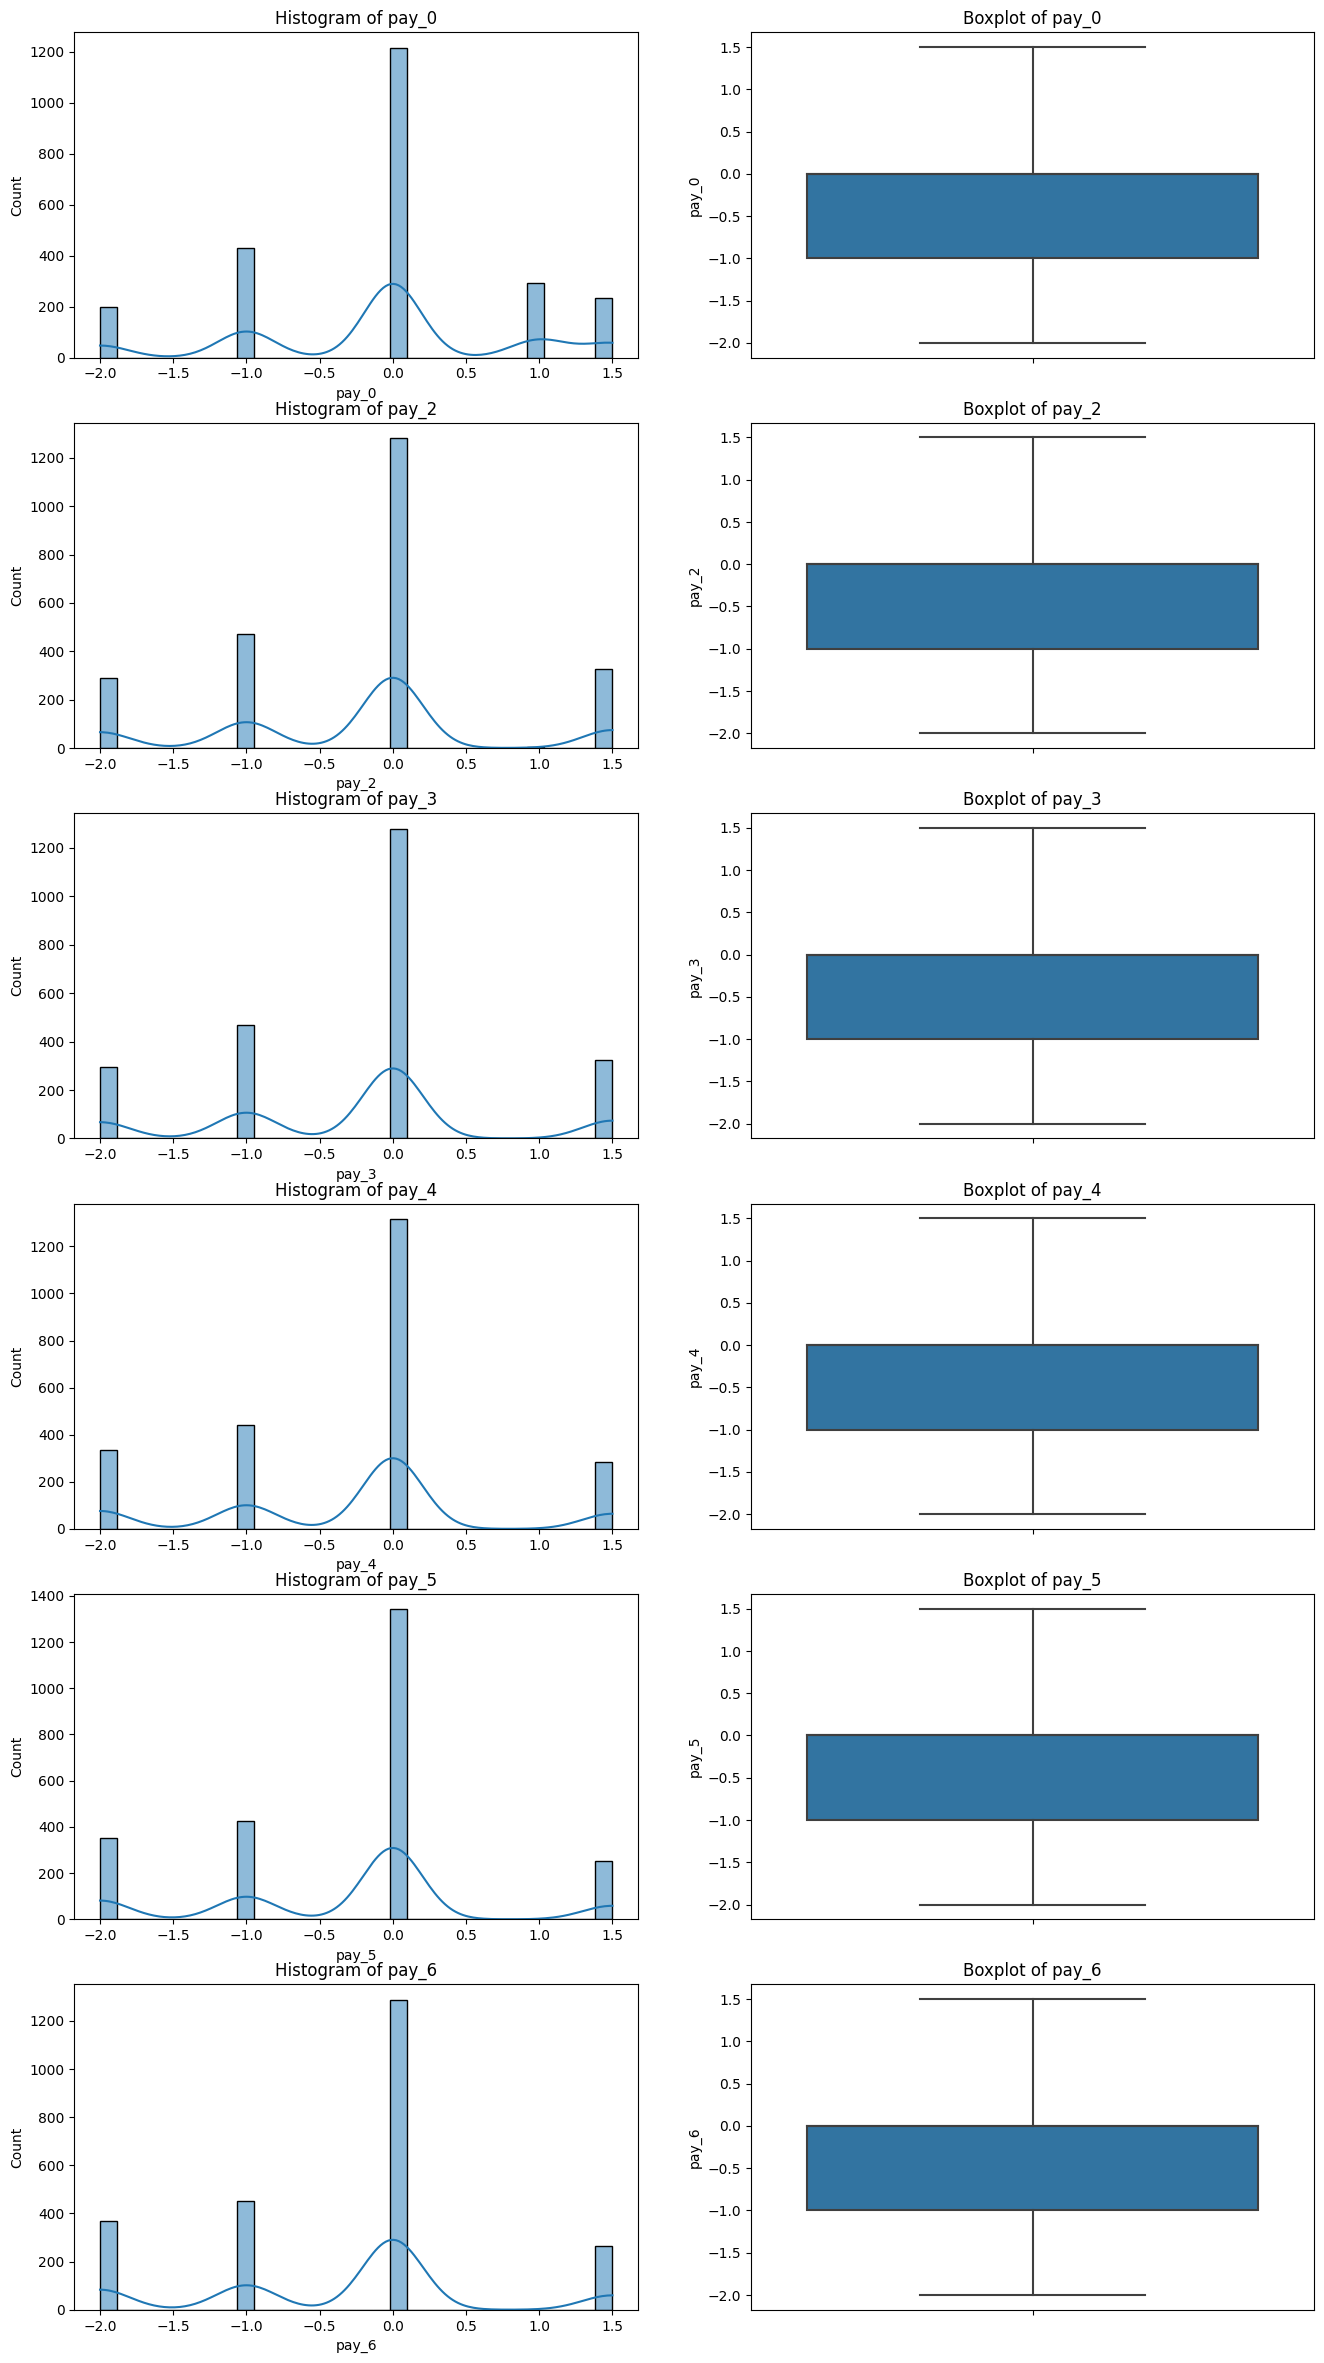

In [29]:
check_1 = [ 'pay_0',
 'pay_2',
 'pay_3',
 'pay_4',
 'pay_5',
 'pay_6']
total_col = len(check_1)
plt.figure(figsize=(16, total_col * 10))
i = 1
for col in check_1:
    plt.subplot(total_col * 2, 2, i)
    sns.histplot(X_train[col], kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    i += 1

    plt.subplot(total_col * 2, 2, i)
    sns.boxplot(y=X_train[col])
    plt.title(f'Boxplot of {col}')
    print(f'Skew of {col}:',X_train[col].skew())
    i += 1

plt.show()

Data limit_balance masih condong ke kiri meskipun outliernya menurut boxplot sudah tidak ada. Untuk data - data pay, data sudah terpusat meskipun datanya masih lebih dominan ke kanan dan menurut boxplot sudah tidak ada outlier

## Feature Selection

Dari hasil analisa diatas hanya data - data **pay** yang memiliki keterkaitan dengan data **default_payment_next_month** sehingga selain data yang disebutkan akan di drop

In [30]:
col_used = ['pay_0',
 'pay_2',
 'pay_3',
 'pay_4',
 'pay_5',
 'pay_6']
X_train = X_train[col_used]
X_test = X_test[col_used]

In [31]:
X_train

,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6
708,0.0,0.0,0.0,0.0,0.0,0.0
1776,1.5,0.0,0.0,1.5,1.5,1.5
1226,0.0,0.0,0.0,0.0,0.0,0.0
2710,0.0,0.0,0.0,0.0,-2.0,-1.0
2419,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...
1341,0.0,0.0,1.5,0.0,0.0,0.0
1026,1.5,0.0,0.0,0.0,0.0,0.0
1450,-1.0,-1.0,1.5,0.0,0.0,0.0
1669,0.0,0.0,0.0,0.0,0.0,-2.0


In [32]:
X_test

,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6
2887,-1.0,-1.0,-2.0,-2.0,-2.0,-2.0
1966,-1.0,1.5,-1.0,-1.0,1.5,1.5
59,0.0,0.0,0.0,0.0,0.0,0.0
2126,-2.0,-2.0,-2.0,-1.0,-1.0,0.0
1302,1.0,1.5,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2830,-1.0,-1.0,-2.0,-2.0,-2.0,-1.0
2701,0.0,0.0,0.0,0.0,-2.0,-2.0
1499,-1.0,-1.0,-2.0,-1.0,0.0,0.0
980,0.0,0.0,0.0,0.0,0.0,-1.0


## Feature Scaling

Melihat summary pada data X_train

In [33]:
X_train.describe()

,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6
count,2371.000000,2371.000000,2371.000000,2371.000000,2371.000000,2371.000000
mean,-0.078237,-0.234289,-0.243146,-0.288064,-0.315057,-0.333404
std,0.925207,0.971232,0.974155,0.965601,0.956469,0.976235
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.500000,1.500000,1.500000,1.500000,1.500000,1.500000


Setelah melihat summary pada data X_train, dapat dilihat bahwa range data pada setiap columnya sangat beragam sehingga perlu dilakukan scaling.

In [34]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train

array([[0.57142857, 0.57142857, 0.57142857, 0.57142857, 0.57142857,
        0.57142857],
       [1.        , 0.57142857, 0.57142857, 1.        , 1.        ,
        1.        ],
       [0.57142857, 0.57142857, 0.57142857, 0.57142857, 0.57142857,
        0.57142857],
       ...,
       [0.28571429, 0.28571429, 1.        , 0.57142857, 0.57142857,
        0.57142857],
       [0.57142857, 0.57142857, 0.57142857, 0.57142857, 0.57142857,
        0.        ],
       [0.57142857, 0.57142857, 0.57142857, 0.57142857, 0.57142857,
        0.57142857]])

## Feature Encoding

Pada kasus ini, seluruh data sudah berbentuk numeric sehingga tidak butuh melakukan feature encoding

# Conceptual Problems

## Apa yang dimaksud dengan criterion pada Decision Tree ? Jelaskan criterion yang kalian pakai dalam kasus ini !

Criterion pada Decision Tree merupakan parameter yang berfungsi untuk mengukur kualitas pemisahan atribut. Pada kasus ini criterion yang digunakan adalan **Gini Index**. Gini merupakan metrics yang mengukur probabilitas dari variabel - variabel yang salah diklasifikasikan. **Gini Index** memiliki nilai dari rentang 0 sampai 1, yang dimana nilai 0 menandakan bahwa variabel pada node tersebut berasal dari 1 class yang sama dan 1 menandakan bahwa variabel variabel pada node tersebut berasal dari berbagai macam class yang teracak.

## Jelaskan apa yang dimaksud dengan pruning pada Tree-based model (alasan, definisi, jenis, dll) !

Pruning dalam bahasa indonesianya adalah pemangkasan. Dalam tree-based model, pruning merupakan sebuah teknik untuk memotong cabang pada pohon model dengan tujuan pohon model tidak terbentuk secara penuh. Pada tree-based model apabila pohon model terbentuk sampai penuh atau dewasa, maka model tersebut cenderung overfit. Sehingga tujuan dari pruning ini untuk menghindari pembuatan model yang overfit. Pruning sendiri ada dua jenis yaitu:
- Pre-pruning\
  Pre-pruning merupakan pruning yang dilakukan sebelum fase training model. Hal ini bisa dikatakan bahwa kita membatasi perkembangan model sebelum model mencapai pertumbuhan akhir. 
- Post-pruning
  Post-pruning merupakan pruning yang dilakukan setelah model sudah bertumbuh dan berkembang secara utuh. Setelah model mencapai pertumbuhan paling akhir atau tidak bisa lagi bertumbuh, pruning akan dilakukan dengan membuang beberapa cabang pohon dari model tersebut

## Bagaimana cara memilih K yang optimal pada KNN ?

Pada basisnya tidak ada nilai K yang ideal pada saat membuat model dari KNN karena setiap data memiliki nilai K optimal yang berbeda, namun sangat disarankan untuk memilih K yang berjumlah ganjil. Hal ini dilakukan untuk menghindari jumlah kelas neighbor yang sama apabila apabila nilai K diambil di angka genap. Selain itu perlu diperhatikan apabila semakin besar nilai K maka model akan semakin kompleks dimana apabila semakin tinggi nilai K maka semakin cenderung model KNN menjadi overfit. Rule of thumb untuk menentukan nilai K yang optimal adalah dengan mengakar kuadratkan total data pada dataset yang ingin di training (`sqrt(N) yang dimana N adalah total data pada dataset training`).

## Jelaskan apa yang dimaksud dengan Cross Validation !

Cross Validation adalah metode statistik yang digunakan untuk mengevaluasi kinerja dari sebuah model dengan cara membagi subset data menjadi dua bagian yaitu data training dan data validation, dimana model akan di training dengan menggunakan data training dan akan divalidasi dengan data validation supaya model dapat menghindari pemilihan data training dan testing yang tidak representatif dengan tujuan untuk memberikan perkiraan yang lebih akurat tentang seberapa baik model dapat memprediksi data yang tidak terlihat sebelumnya.  

## Apa yang dimaksud dengan metrics-metrics berikut : Accuracy, Precision, Recall, F1 Score, dan kapan waktu yang tepat untuk menggunakannya ?

Sebelum memasuki kedalam metric dalam klasifikasi, perlu diketahui bahwa dalam klasifikasi ada 4 kategori label yaitu:
- True Positive (TP)
  Kategori yang nilai prediksinya dan nilai aktualnya positif
- True Negative (TN)
  Kategori yang nilai prediksinya dan nilai aktualnya negatif
- False Positive (FP)
  Kategori yang nilai prediksinya positif tapi nilai aktualnya negatif
- False Negative (FN)
  Kategori yang nilai prediksinya negatif tapi nilai aktualnya positif

Setelah mengetahui 4 kategori label tersebut baru kita dapat mengartikan metrics metrics pada classification yaitu:
- Accuracy
  Metrics yang memberikan persentase nilai prediksi yang sesuai dengan nilai aktualnya
  Formula = `(TP + TN)/(TP + FP + TN + FN)`
- Precision
  Metrics yang memberikan persentase nilai positif dari seluruh nilai positif yang diprediksi oleh model
  Formula = `TP / (TP + FP)`
- Recall
  Metrics yang memberikan persentase nilai positif dari seluruh nilai positif yang nilai aktualnya benar benar positif
  Formula = `TP / (TP + FN)`
- F1-score
  Harmonic mean dari nilai precision dan recall 
  Formula = `2 * Recall * Precision / (Recall + Precision)`

Dalam penggunaannya accuracy merupakan metric yang baik apabila label pada sebuat dataset memiliki jumlah data yang seimbang. Apabila data tidak seimbang, maka lebih baik menggunakan metrics lain. Ketika datanya tidak seimbang, dan kita ingin meminimalkan nilai dari False Positive maka lebih baik menggunakan metrics precision, begitu pula apabila kita ingin meminimalkan nilai dari False Negative maka lebih baik menggunakan metrics recall. Namun apabila kita tidak mengetahui dari kedua kategori tersebut yang mana yang ingin diminimalkan, maka lebih baik menggunakan metrics F1-score yang merupakan harmonic mean dari nilai precision dan juga recall

# Model Definition

Pada kesempatan ini, model yang digunakan ada 6 yaitu model **Logistic Regression**, **SVM**, **KNN**, **Naive Bayes**, **Decision Tree**, dan **Random Forest**. Nantinya 2 model dengan performa terbaik pada base modelnya akan di tuning lagi, lalu model terbaik setelah dituning akan disimpan untuk melakukan prediksi pembatalan kartu kredit di bulan depannya

In [35]:
log_reg = LogisticRegression()

In [36]:
svm_model = SVC()

In [37]:
knn_model = KNeighborsClassifier()

In [38]:
nb_model = GaussianNB()

In [39]:
dt_model = DecisionTreeClassifier()

In [40]:
rf_model = RandomForestClassifier()

# Model Training

## Cross Validation

Selama cross validation, metric yang digunakan adalah f1-score dari label 1

In [41]:
f1_score_train_cross_val = cross_val_score(log_reg, 
                                           X_train, 
                                           y_train, 
                                           cv=5, 
                                           scoring='f1')

print('F1 Score - All - Cross Validation  - Logistic Regression  : ', f1_score_train_cross_val)
print('F1 Score - Mean - Cross Validation - Logistic Regression : ', f1_score_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  - Logistic Regression  : ', f1_score_train_cross_val.std())
print('F1 Score - Range of Test-Set       - Logistic Regression  : ', (f1_score_train_cross_val.mean()-f1_score_train_cross_val.std()) , '-', (f1_score_train_cross_val.mean()+f1_score_train_cross_val.std()))

F1 Score - All - Cross Validation  - Logistic Regression  :  [0.35555556 0.36090226 0.35384615 0.35971223 0.42028986]
F1 Score - Mean - Cross Validation - Logistic Regression :  0.3700612100658196
F1 Score - Std - Cross Validation  - Logistic Regression  :  0.02524775899088019
F1 Score - Range of Test-Set       - Logistic Regression  :  0.34481345107493944 - 0.39530896905669977


In [42]:
f1_score_train_cross_val = cross_val_score(svm_model, 
                                           X_train, 
                                           y_train, 
                                           cv=5, 
                                           scoring='f1')

print('F1 Score - All - Cross Validation  - SVM : ', f1_score_train_cross_val)
print('F1 Score - Mean - Cross Validation - SVM : ', f1_score_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  - SVM : ', f1_score_train_cross_val.std())
print('F1 Score - Range of Test-Set       - SVM : ', (f1_score_train_cross_val.mean()-f1_score_train_cross_val.std()) , '-', (f1_score_train_cross_val.mean()+f1_score_train_cross_val.std()))

F1 Score - All - Cross Validation  - SVM :  [0.47682119 0.46540881 0.53164557 0.45       0.56287425]
F1 Score - Mean - Cross Validation - SVM :  0.4973499636403371
F1 Score - Std - Cross Validation  - SVM :  0.0427862314806029
F1 Score - Range of Test-Set       - SVM :  0.4545637321597342 - 0.54013619512094


In [43]:
f1_score_train_cross_val = cross_val_score(knn_model, 
                                           X_train, 
                                           y_train, 
                                           cv=5, 
                                           scoring='f1')

print('F1 Score - All - Cross Validation  - KNN : ', f1_score_train_cross_val)
print('F1 Score - Mean - Cross Validation - KNN : ', f1_score_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  - KNN : ', f1_score_train_cross_val.std())
print('F1 Score - Range of Test-Set       - KNN : ', (f1_score_train_cross_val.mean()-f1_score_train_cross_val.std()) , '-', (f1_score_train_cross_val.mean()+f1_score_train_cross_val.std()))

F1 Score - All - Cross Validation  - KNN :  [0.45033113 0.44171779 0.54117647 0.4494382  0.47619048]
F1 Score - Mean - Cross Validation - KNN :  0.471770813252952
F1 Score - Std - Cross Validation  - KNN :  0.03660128009694902
F1 Score - Range of Test-Set       - KNN :  0.435169533156003 - 0.508372093349901


In [44]:
f1_score_train_cross_val = cross_val_score(nb_model, 
                                           X_train, 
                                           y_train, 
                                           cv=5, 
                                           scoring='f1')

print('F1 Score - All - Cross Validation  - Naive Bayes : ', f1_score_train_cross_val)
print('F1 Score - Mean - Cross Validation - Naive Bayes : ', f1_score_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  - Naive Bayes : ', f1_score_train_cross_val.std())
print('F1 Score - Range of Test-Set       - Naive Bayes : ', (f1_score_train_cross_val.mean()-f1_score_train_cross_val.std()) , '-', (f1_score_train_cross_val.mean()+f1_score_train_cross_val.std()))

F1 Score - All - Cross Validation  - Naive Bayes :  [0.47674419 0.53846154 0.48       0.43428571 0.54822335]
F1 Score - Mean - Cross Validation - Naive Bayes :  0.4955429578095144
F1 Score - Std - Cross Validation  - Naive Bayes :  0.0423430172629891
F1 Score - Range of Test-Set       - Naive Bayes :  0.4531999405465253 - 0.5378859750725035


In [45]:
f1_score_train_cross_val = cross_val_score(dt_model, 
                                           X_train, 
                                           y_train, 
                                           cv=5, 
                                           scoring='f1')

print('F1 Score - All - Cross Validation  - Decision Tree : ', f1_score_train_cross_val)
print('F1 Score - Mean - Cross Validation - Decision Tree : ', f1_score_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  - Decision Tree : ', f1_score_train_cross_val.std())
print('F1 Score - Range of Test-Set       - Decision Tree : ', (f1_score_train_cross_val.mean()-f1_score_train_cross_val.std()) , '-', (f1_score_train_cross_val.mean()+f1_score_train_cross_val.std()))

F1 Score - All - Cross Validation  - Decision Tree :  [0.43312102 0.48484848 0.5398773  0.42857143 0.56804734]
F1 Score - Mean - Cross Validation - Decision Tree :  0.4908931140839594
F1 Score - Std - Cross Validation  - Decision Tree :  0.055875521782349086
F1 Score - Range of Test-Set       - Decision Tree :  0.4350175923016103 - 0.5467686358663085


In [46]:
f1_score_train_cross_val = cross_val_score(rf_model, 
                                           X_train, 
                                           y_train, 
                                           cv=5, 
                                           scoring='f1')

print('F1 Score - All - Cross Validation  - Random Forest : ', f1_score_train_cross_val)
print('F1 Score - Mean - Cross Validation - Random Forest : ', f1_score_train_cross_val.mean())
print('F1 Score - Std - Cross Validation  - Random Forest : ', f1_score_train_cross_val.std())
print('F1 Score - Range of Test-Set       - Random Forest : ', (f1_score_train_cross_val.mean()-f1_score_train_cross_val.std()) , '-', (f1_score_train_cross_val.mean()+f1_score_train_cross_val.std()))

F1 Score - All - Cross Validation  - Random Forest :  [0.46753247 0.47560976 0.5748503  0.44311377 0.56969697]
F1 Score - Mean - Cross Validation - Random Forest :  0.5061606530366571
F1 Score - Std - Cross Validation  - Random Forest :  0.055055488777488684
F1 Score - Range of Test-Set       - Random Forest :  0.45110516425916847 - 0.5612161418141458


Dari hasil valisadi silang, dua model yang memiliki performa terbaik adalah **Random Forest** rata - rata F1 score pada label 1 selama validasi silang sebesar **52,77%** 

## Hyperparameter Tuning

In [47]:
n_estimators = [200,300,400,500,600]
max_features = ['sqrt']
max_depth = [120]
min_samples_split = [8,9,10,11,12]
min_samples_leaf = [6,8,10]
param_grid = {'n_estimators': n_estimators,
               'max_features':max_features,
               'max_depth':max_depth,
               'min_samples_split':min_samples_split,
               'min_samples_leaf':min_samples_leaf,
               'criterion':['gini']}

rf_grid = GridSearchCV(estimator=rf_model,
                         param_grid=param_grid,
                         cv=5,
                         n_jobs=-1,
                         verbose=2, 
                         scoring='f1')
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [120],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [6, 8, 10],
                         'min_samples_split': [8, 9, 10, 11, 12],
                         'n_estimators': [200, 300, 400, 500, 600]},
             scoring='f1', verbose=2)

In [48]:
rf_model.fit(X_train,y_train)

RandomForestClassifier()

In [49]:
rf_grid.best_params_

{'criterion': 'gini',
 'max_depth': 120,
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 300}

# Model Evaluation

Evaluasi model akan menggunakan metric F1-score untuk melihat seberapa tepat model melakukan klasifikasi. Hal ini dikarenakan data pada kasus ini termasuk imbalanced sehingga metric F1-score lebih cocok untuk melihat ketepatan dari model klasifikasi sesuai dengan classnya. Walau begitu, metric accuracy juga akan dilihat untuk melihat performa ketepatan model secara keseluruhan. 

In [50]:
y_pred_train = rf_grid.predict(X_train)
y_pred_test = rf_grid.predict(X_test)
y_pred_train

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

Accuracy Score - Train: 84.05735976381273
Accuracy Score - Test: 84.65430016863407
F1 Score for label 0 - Train: 90.45936395759718
F1 Score for label 0 - Test: 90.66666666666667
F1 Score for label 1 - Train: 51.53846153846155
F1 Score for label 1 - Test: 56.872037914691944
Average of F1 Score - Train: 70.99891274802937
Average of F1 Score - Test: 73.76935229067931
Classification Report : 
               precision    recall  f1-score   support

           0       0.87      0.95      0.91       466
           1       0.71      0.47      0.57       127

    accuracy                           0.85       593
   macro avg       0.79      0.71      0.74       593
weighted avg       0.84      0.85      0.83       593
 

Confusion Matrix      : 


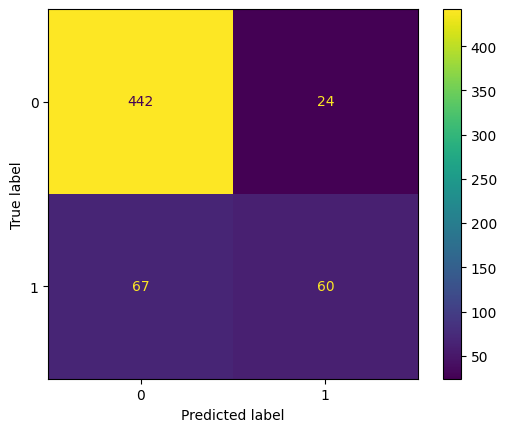

In [51]:
print('Accuracy Score - Train:', accuracy_score(y_train, y_pred_train) * 100)
print('Accuracy Score - Test:', accuracy_score(y_test, y_pred_test) * 100)
f1_score_total_train = 0
f1_score_total_test = 0
for i in y_train.unique():
    print(f'F1 Score for label {i} - Train:', f1_score(y_train, y_pred_train, pos_label=i) * 100)
    print(f'F1 Score for label {i} - Test:', f1_score(y_test, y_pred_test, pos_label=i) * 100)
    f1_score_total_train += f1_score(y_train, y_pred_train, pos_label=i) * 100
    f1_score_total_test += f1_score(y_test, y_pred_test, pos_label=i) * 100
print('Average of F1 Score - Train:', f1_score_total_train/len(y_train.unique()))
print('Average of F1 Score - Test:', f1_score_total_test/len(y_train.unique()))
print('Classification Report : \n', classification_report(y_test, y_pred_test), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test)).plot())

In [52]:
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)
y_pred_train

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

Accuracy Score - Train: 85.74441164065794
Accuracy Score - Test: 83.47386172006746
F1 Score for label 0 - Train: 91.32888660851718
F1 Score for label 0 - Test: 89.79166666666667
F1 Score for label 1 - Train: 59.95260663507109
F1 Score for label 1 - Test: 56.63716814159291
Average of F1 Score - Train: 75.64074662179414
Average of F1 Score - Test: 73.21441740412979
Classification Report : 
               precision    recall  f1-score   support

           0       0.87      0.92      0.90       466
           1       0.65      0.50      0.57       127

    accuracy                           0.83       593
   macro avg       0.76      0.71      0.73       593
weighted avg       0.82      0.83      0.83       593
 

Confusion Matrix      : 


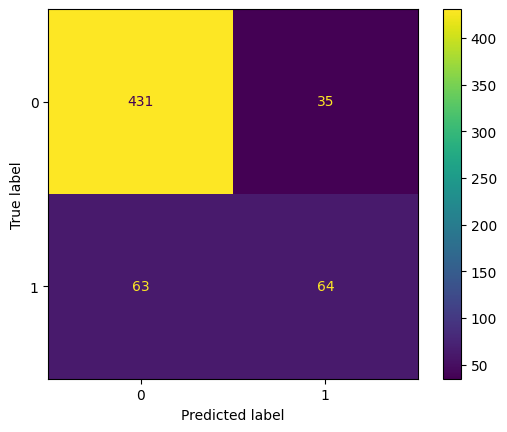

In [53]:
print('Accuracy Score - Train:', accuracy_score(y_train, y_pred_train) * 100)
print('Accuracy Score - Test:', accuracy_score(y_test, y_pred_test) * 100)
f1_score_total_train = 0
f1_score_total_test = 0
for i in y_train.unique():
    print(f'F1 Score for label {i} - Train:', f1_score(y_train, y_pred_train, pos_label=i) * 100)
    print(f'F1 Score for label {i} - Test:', f1_score(y_test, y_pred_test, pos_label=i) * 100)
    f1_score_total_train += f1_score(y_train, y_pred_train, pos_label=i) * 100
    f1_score_total_test += f1_score(y_test, y_pred_test, pos_label=i) * 100
print('Average of F1 Score - Train:', f1_score_total_train/len(y_train.unique()))
print('Average of F1 Score - Test:', f1_score_total_test/len(y_train.unique()))
print('Classification Report : \n', classification_report(y_test, y_pred_test), '\n')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test)).plot())

Dari hasil evaluasi diatas, model **Random Forest** memiliki rata - rata f1-score sebesar **73,38%** dan accuracy sebesar **84,31%**. Dimana model **Random Forest** juga berhasil menghasilkan performa yang lebih baik setelah dilakukan hyperparameter tuning dimana f1-score pada label 1 sebelum di tuning memiliki score **52,77%** dan setelah di tuning mendapat score **56,33%** atau kenaikan f1-score sebesar **4,34%**. Selain itu model **Random Forest** juga dikatakan sudah good fit karena hasil evaluasi pada data train dengan data test tidak berbeda jauh dimana data train memiliki rata-rata f1-score sebesar **71,23%** dan pada data test sebesar **73,38%**.

# Model Saving

In [54]:
with open('list_col_used.txt', 'w') as file_1:
  json.dump(col_used, file_1)

with open('model_scaler.pkl', 'wb') as file_2:
  pickle.dump(scaler, file_2)

with open('rf_model.pkl', 'wb') as file_3:
  pickle.dump(rf_grid, file_3)

# Model Inference

Untuk model inference dapat di cek pada file `h8dsft_P1M1_Arvin Melvillo_Inference.ipynb`

# Pengambilan Kesimpulan

Data terdiri dari 24 kolom yang dimana data yang memiliki keterkaitan dengan **default_payment_next_month** hanya data - data **pay**, saja. \
Dari 6 model yang telah dijalankan, performa terbaik dengan validasi silang didapatkan oleh base model **Random Forest** dengan rata - rata nilai F1 score pada label 1 selama validasi silang sebesar **52,77%**. Setelah dilakukan Hyperparameter tuning, model **Random Forest** mengalami peningkatan kinerja dengan nilai f1 score pada label 1 sebesar **56,33%** atau kenaikan f1-score sebesar **4,34%**. \
Hasil evaluasi model **Random Forest** mendapatkan rata - rata f1-score sebesar **73,38%** dan accuracy sebesar **84,31%** . Selain itu model **Random Forest** juga dikatakan sudah good fit karena hasil evaluasi pada data train dengan data test tidak berbeda jauh dimana data train memiliki rata-rata f1-score sebesar **71,23%** dan pada data test sebesar **73,38%**. \
Untuk improvement kedepannya, dapat dimulai dari mengumpulkan data supaya data menjadi lebih seimbang antara kelompok **kartu kredit yang dibatalkan** dengan kelompok **kartu kredit yang tidak dibatalkan**.